In [ ]:
%tensorflow_version 2.x

In [ ]:
import tensorflow as tf
tf.__version__

'2.8.0'

In [ ]:
#使用混合精度(Mixed precision)能減少記憶體使用量與訓練時間，避免出現記憶體不足的錯誤，未來在本系列TensorFlow2基礎篇會介紹
from tensorflow.keras import mixed_precision
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_global_policy(policy)
print('Compute dtype: %s' % policy.compute_dtype)
print('Variable dtype: %s' % policy.variable_dtype)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import random
os.environ['TF_DETERMINISTIC_OPS'] ='1'
os.environ['TF_CUDNN_DETERMINISTIC']='1'
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)
SEED=1
os.environ['PYTHONHASHSEED']=str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# 1. 資料準備

In [ ]:
from tensorflow.keras.datasets import cifar10

In [ ]:
(x_img_train,y_label_train),\
(x_img_test,y_label_test)=cifar10.load_data() 

170508288/170498071 [==============================] - 2s 0us/step


In [ ]:
y_label_train=y_label_train.reshape(-1)
y_label_test=y_label_test.reshape(-1)

In [ ]:
print("train data:",'images:',x_img_train.shape,"labels:",y_label_train.shape) 
print("test  data:",'images:',x_img_test.shape ," labels:",y_label_test.shape) 

train data: images: (50000, 32, 32, 3) labels: (50000,)
test  data: images: (10000, 32, 32, 3)  labels: (10000,)


In [ ]:
x_img_train_normalize = x_img_train.astype('float32') / 255.0
x_img_test_normalize = x_img_test.astype('float32') / 255.0

In [ ]:
from tensorflow.keras import utils
y_train_onehot = utils.to_categorical(y_label_train)
y_test_onehot = utils.to_categorical(y_label_test)

In [ ]:
from sklearn.model_selection import train_test_split
x_img_train_normalize,x_img_val_normalize,y_train_onehot,y_val_onehot=\
      train_test_split(x_img_train_normalize,y_train_onehot, 
              test_size=0.2, random_state=888)

In [ ]:
print("train data:",'images:',x_img_train_normalize.shape,
   " labels:",y_train_onehot.shape) 
print("val data:",'images:',x_img_val_normalize.shape,
   " labels:",y_val_onehot.shape) 
print("test  data:",'images:',x_img_test_normalize.shape ,
   " labels:",y_test_onehot.shape) 

train data: images: (40000, 32, 32, 3)  labels: (40000, 10)
val data: images: (10000, 32, 32, 3)  labels: (10000, 10)
test  data: images: (10000, 32, 32, 3)  labels: (10000, 10)


# 建立模型

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input,Conv2D,Dropout, MaxPooling2D,Dense,Activation,BatchNormalization, Flatten

In [ ]:
def block(p_bname,p_filters,p_conv,p_drop_rate,p_is_bn):
  for i in range(p_conv):
    model.add(Conv2D(filters=p_filters,kernel_size=(3,3),
             activation='relu',padding='same',
             name=p_bname+'_conv'+str(i)))
    if p_is_bn:model.add(BatchNormalization(name=p_bname+'_Bn'+str(i)))
  model.add(MaxPooling2D(pool_size=(2, 2),name=p_bname+'_pool'))
  if p_is_bn:model.add(BatchNormalization(name=p_bname+'_Bn_pool'))
  if p_drop_rate>0: model.add(Dropout(drop_rate,name=p_bname+'_Dr'))  

In [ ]:
drop_rate=0
model = Sequential()
model.add(Input(shape=(32, 32,3)))
block(p_bname='B1',p_filters=32,p_conv=6,
   p_drop_rate=drop_rate,p_is_bn=True)
block(p_bname='B2',p_filters=64,p_conv=6,
   p_drop_rate=drop_rate,p_is_bn=True)
block(p_bname='B3',p_filters=128,p_conv=6,
   p_drop_rate=drop_rate,p_is_bn=True)
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(10, activation='softmax'))

In [ ]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 B1_conv0 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 B1_Bn0 (BatchNormalization)  (None, 32, 32, 32)       128       
                                                                 
 B1_conv1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 B1_Bn1 (BatchNormalization)  (None, 32, 32, 32)       128       
                                                                 
 B1_conv2 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 B1_Bn2 (BatchNormalization)  (None, 32, 32, 32)       128       
                                                                 
 B1_conv3 (Conv2D)           (None, 32, 32, 32)        9

# 訓練模型

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc'])

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(patience=15)

In [ ]:
!mkdir Model

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
filepath="Model/Cifar_C5P1_ErAuBn.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc',
                verbose=1, save_best_only=True, mode='max')

In [ ]:
BATCH_SIZE=200

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
datagen = ImageDataGenerator(
    rotation_range=30,horizontal_flip=True,
    width_shift_range=0.2,height_shift_range=0.2,
    zoom_range=0.2  )

In [ ]:
BATCH_SIZE=200

In [ ]:
train_history=model.fit(
  datagen.flow(x=x_img_train_normalize,
         y=y_train_onehot,
         batch_size=BATCH_SIZE),
  steps_per_epoch = len(x_img_train_normalize) / BATCH_SIZE, 
  validation_data=(x_img_val_normalize, y_val_onehot),
  epochs=200,callbacks=[early_stopping,checkpoint]) 

Epoch 1/200
200/200 [==============================] - ETA: 0s - loss: 1.8099 - acc: 0.3435
Epoch 1: val_acc improved from -inf to 0.10490, saving model to Model/Cifar_C5P1_ErAuBn.h5
200/200 [==============================] - 40s 138ms/step - loss: 1.8099 - acc: 0.3435 - val_loss: 3.3804 - val_acc: 0.1049
Epoch 2/200
200/200 [==============================] - ETA: 0s - loss: 1.4751 - acc: 0.4663
Epoch 2: val_acc improved from 0.10490 to 0.28120, saving model to Model/Cifar_C5P1_ErAuBn.h5
200/200 [==============================] - 27s 135ms/step - loss: 1.4751 - acc: 0.4663 - val_loss: 2.2877 - val_acc: 0.2812
Epoch 3/200
200/200 [==============================] - ETA: 0s - loss: 1.3427 - acc: 0.5174
Epoch 3: val_acc improved from 0.28120 to 0.52190, saving model to Model/Cifar_C5P1_ErAuBn.h5
200/200 [==============================] - 27s 135ms/step - loss: 1.3427 - acc: 0.5174 - val_loss: 1.5298 - val_acc: 0.5219
Epoch 4/200
200/200 [==============================] - ETA: 0s - loss: 1.

In [ ]:
import matplotlib.pyplot as plt
def show_train_history(train_history,train_key,valid_key):
    plt.plot(train_history.history[train_key],'--')
    plt.plot(train_history.history[valid_key])
    plt.title('Train History')
    plt.ylabel(train_key)
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

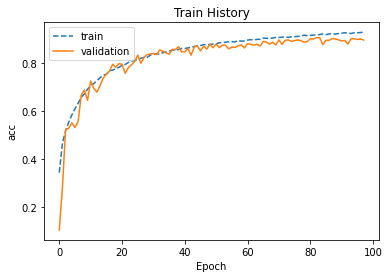

In [ ]:
show_train_history(train_history,'acc','val_acc')

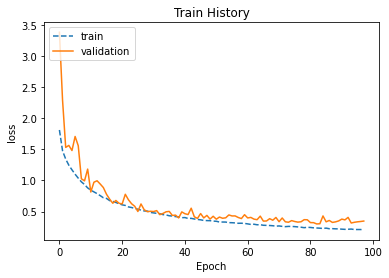

In [ ]:
show_train_history(train_history,'loss','val_loss')

# 評估模型準確率

In [ ]:
scores = model.evaluate(x_img_test_normalize,y_test_onehot)

313/313 [==============================] - 1s 4ms/step - loss: 0.3611 - acc: 0.8880


In [ ]:
print('test_loss=',scores[0],'test_acc=',scores[1])

test_loss= 0.3611401617527008 test_acc= 0.8880000114440918


# 載入最佳模型

In [ ]:
model.load_weights(filepath)

In [ ]:
scores = model.evaluate(x_img_test_normalize,y_test_onehot)
scores[1]

313/313 [==============================] - 1s 4ms/step - loss: 0.3207 - acc: 0.8943


0.8942999839782715

In [ ]:
print('test_loss=',scores[0],'test_acc=',scores[1])

test_loss= 0.32067784667015076 test_acc= 0.8942999839782715


# 進行預測

In [ ]:
probability=model.predict(x_img_test_normalize)

In [ ]:
prediction=tf.argmax(probability, axis=-1).numpy()

In [ ]:
prediction[:10]

array([3, 8, 1, 0, 6, 6, 1, 6, 3, 1])

# 查看預測結果

In [ ]:
import matplotlib.pyplot as plt 

In [ ]:
label_dict={0:"airplane",1:"automobile",2:"bird",3:"cat",4:"deer",
      5:"dog",6:"frog",7:"horse",8:"ship",9:"truck"}

In [ ]:
def plot_images_labels_prediction(
    images,labels,prediction,idx,num=10):
    fig = plt.gcf().set_size_inches(12, 12)    
    if num>25: num=25 
    for i in range(0, num):
        ax=plt.subplot(5,5, 1+i)
        ax.imshow(images[idx], cmap='binary')
        title= str(idx)+',' +label_dict[labels[idx]]
        if len(prediction)>0:
            title+="=>"+label_dict[prediction[idx]]
        ax.set_title(title,fontsize=10) 
        ax.set_xticks([]);ax.set_yticks([])        
        idx+=1 
    plt.show()

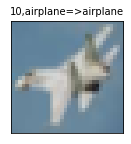

In [ ]:
plot_images_labels_prediction(x_img_test,y_label_test,prediction,idx=10,num=1)

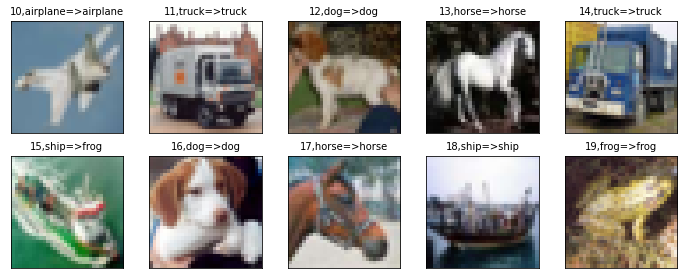

In [ ]:
plot_images_labels_prediction(x_img_test,y_label_test,prediction,idx=10,num=10)

# 查看預測機率

In [ ]:
def show_predicted_probability(
    images,labels,prediction,probability,idx):
  plt.figure(figsize=(1,1));
  plt.xticks([]);plt.yticks([])
  plt.imshow(images[idx],cmap='binary')
  plt.show()
  print('label:',label_dict[labels[idx]],
        'predict:',label_dict[prediction[idx]]) 
  for i in range(10):
    print('%-10s Probability:%.9f'%(label_dict[i],probability[idx][i]))      

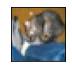

label: cat predict: cat
airplane   Probability:0.000011833
automobile Probability:0.000108128
bird       Probability:0.002081461
cat        Probability:0.969769955
deer       Probability:0.000018651
dog        Probability:0.014809544
frog       Probability:0.013139381
horse      Probability:0.000057494
ship       Probability:0.000003006
truck      Probability:0.000000500


In [ ]:
show_predicted_probability(x_img_test,y_label_test, 
             prediction,probability,0) 

# confusion matrix

In [ ]:
import pandas as pd

In [ ]:
pd.crosstab(y_label_test,prediction,rownames=['label'],colnames=['predict'])

predict,0,1,2,3,4,5,6,7,8,9
label,,,,,,,,,,
0,898,5,26,5,3,3,7,7,22,24
1,2,960,2,2,0,0,2,0,0,32
2,22,2,878,18,24,16,27,9,3,1
3,8,5,44,749,22,95,35,23,7,12
4,5,0,26,15,901,13,22,15,0,3
5,2,1,21,74,20,839,20,19,0,4
6,4,0,13,9,6,4,959,4,0,1
7,4,1,14,9,39,11,3,915,0,4
8,45,18,6,3,0,3,5,1,900,19


In [ ]:
df = pd.DataFrame({'label':y_label_test, 'predict':prediction})

In [ ]:
df[:5]

,label,predict
0,3,3
1,8,8
2,8,1
3,0,0
4,6,6


In [ ]:
df[(df.label==5)&(df.predict==3)]

,label,predict
128,5,3
158,5,3
478,5,3
483,5,3
551,5,3
...,...,...
9380,5,3
9414,5,3
9586,5,3
9657,5,3


# 查看預測錯誤資料

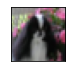

label: dog predict: dog
airplane   Probability:0.005858543
automobile Probability:0.000188851
bird       Probability:0.002036925
cat        Probability:0.306659818
deer       Probability:0.004232339
dog        Probability:0.658761561
frog       Probability:0.000507035
horse      Probability:0.018507961
ship       Probability:0.000025713
truck      Probability:0.003221272


In [ ]:
show_predicted_probability(x_img_test,y_label_test,prediction,probability,42)

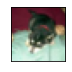

label: dog predict: cat
airplane   Probability:0.000055742
automobile Probability:0.000044141
bird       Probability:0.000886632
cat        Probability:0.632720888
deer       Probability:0.000854827
dog        Probability:0.355746537
frog       Probability:0.006832920
horse      Probability:0.002809406
ship       Probability:0.000001042
truck      Probability:0.000047845


In [ ]:
show_predicted_probability(x_img_test,y_label_test,prediction,probability,128)

#建立儲存模型路徑

In [ ]:
import os
def Save_model_to_gdrive(model_dir,model_name): 
  path= model_dir+model_name
  os.makedirs(path,exist_ok=True) 
  try:
    model_json = model.to_json()  
    with open(path+"structure.json","w") as json_file:
      json_file.write(model_json)
    model.save(path+"whole.h5",save_format='h5')    
  except: 
    print('No structure')
  model.save(path+"SavedModel",save_format='tf')  
  model.save_weights(path+"weight.h5")    
  os.system("cp -r Model drive/MyDrive") 

In [ ]:
Save_model_to_gdrive(model_dir='Model/',model_name='CifarCNN/')

INFO:tensorflow:Assets written to: Model/CifarCNN/SavedModel/assets


In [ ]:
ls drive/MyDrive/Model

Cifar_C5P1_ErAuBn.h5  CifarCNN/  CifarCNNFunc/  CifarCNNSub/


In [ ]:
ls -l drive/MyDrive/Model

total 16038
-rw------- 1 root root 16410384 Mar 12 05:57 Cifar_C5P1_ErAuBn.h5
drwx------ 3 root root     4096 Mar 12 05:57 CifarCNN/
drwx------ 2 root root     4096 Feb  2 14:35 CifarCNNFunc/
drwx------ 2 root root     4096 Sep  5  2021 CifarCNNSub/
